In [9]:
import numpy as np
import cv2 as cv
import va
from ipywidgets import interact

In [10]:
video = cv.VideoCapture("./simpsons abbey road.mp4")
prev = None
fm = []
thr = 50
while True:
    ret, frame = video.read()
    if not ret:
        # No more frames
        break
    f = cv.cvtColor(frame, cv.COLOR_BGR2GRAY).astype(np.uint16)
    if prev is not None:
        mask = np.zeros_like(f)
        mask[np.abs(f - prev) > thr] = 255
        fm.append((frame, mask))
    prev = f
video.release()


In [11]:
@interact(i=(0,len(fm)-1))
def frameVision(i=0):
    va.show(fm[i][1])


interactive(children=(IntSlider(value=0, description='i', max=241), Output()), _dom_classes=('widget-interact'…

In [12]:
mog = cv.createBackgroundSubtractorMOG2(detectShadows=False)

video = cv.VideoCapture("./simpsons abbey road.mp4")
fm = []
while True:
    ret, frame = video.read()
    if not ret:
        break
    f = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    mask = mog.apply(f)
    fm.append((frame, mask))
video.release()

In [13]:
@interact(i=(0,len(fm)-1))
def frameVisionMOG(i=0):
    va.show(fm[i][1])


interactive(children=(IntSlider(value=0, description='i', max=242), Output()), _dom_classes=('widget-interact'…

## Improve the FRAME
1. Resize del frame in modo da mantenere il focus solamente sull'oggetto in movimento

In [14]:
MASK_SF = 2.0

video = cv.VideoCapture("./simpsons abbey road.mp4")
fm1 = []
while True:
    ret, frame = video.read()
    if not ret:
        break
    f = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    mask = mog.apply(cv.resize(f, None, fx=1/MASK_SF, fy=1/MASK_SF))
    n_mask = cv.resize(mask, None, fx=MASK_SF, fy=MASK_SF, interpolation=cv.INTER_NEAREST)
    fm1.append((frame, mask))
video.release()


In [15]:
@interact(i=(0,len(fm1)-1))
def frameVisionMOG2(i=0):
    va.show(fm1[i][1])


interactive(children=(IntSlider(value=0, description='i', max=242), Output()), _dom_classes=('widget-interact'…

2. Utilizzo delle componenti connesse per eliminare tutte le componenti con area minore di una certa soglia

In [16]:
MASK_SF = 2.0

video = cv.VideoCapture("./simpsons abbey road.mp4")
fm2 = []
while True:
    ret, frame = video.read()
    if not ret:
        break
    f = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    mask = mog.apply(cv.resize(f, None, fx=1/MASK_SF, fy=1/MASK_SF))
    n, cc, stats, _ = cv.connectedComponentsWithStats(mask)
    small = [i for i in range(1, n) if stats[i, cv.CC_STAT_AREA] < 70]
    mask[np.isin(cc, small)] = 0
    n_mask = cv.resize(mask, None, fx=MASK_SF, fy=MASK_SF, interpolation=cv.INTER_NEAREST)
    fm2.append((frame, mask))
video.release()


In [17]:
@interact(i=(0,len(fm1)-1))
def frameVisionMOG2(i=0):
    va.show(fm2[i][1])


interactive(children=(IntSlider(value=0, description='i', max=242), Output()), _dom_classes=('widget-interact'…

3. Riempio i buchi all'interno delle componenti connesse

In [41]:
MASK_SF = 2.0
se = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
video = cv.VideoCapture("./simpsons abbey road.mp4")
fm3 = []
while True:
    ret, frame = video.read()
    if not ret:
        break
    f = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    mask = mog.apply(cv.resize(f, None, fx=1/MASK_SF, fy=1/MASK_SF))
    
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, se)
    n, cc, stats, _ = cv.connectedComponentsWithStats(mask, connectivity=4)
    small = [i for i in range(1, n) if stats[i, cv.CC_STAT_AREA] < 70]
    mask[np.isin(cc, small)] = 0
    
    n, cc, stats, _ = cv.connectedComponentsWithStats(mask, connectivity=4)
    holes = [i for i in range(1, n) if stats[i, cv.CC_STAT_AREA] < 2000]
    mask[np.isin(cc, holes)] = 255
    
    
    n_mask = cv.resize(mask, None, fx=MASK_SF, fy=MASK_SF, interpolation=cv.INTER_NEAREST)
    fm3.append((frame, mask))
video.release()


In [42]:
@interact(i=(0,len(fm1)-1))
def frameVisionMOG2(i=0):
    va.show(fm3[i][1])


interactive(children=(IntSlider(value=0, description='i', max=242), Output()), _dom_classes=('widget-interact'…

## Mean SHIFT

In [26]:
term_crit= ( cv.TERM_CRITERIA_EPS | cv.TermCriteria_COUNT, 10, 1)
MIN_ARE_IN_WND = 20
MIN_AREA = 500

In [39]:
def get_window_hist(i, frame, stats, mask):
    x, y = stats[i, cv.CC_STAT_LEFT], stats[i, cv.CC_STAT_TOP]
    w, h = stats[i, cv.CC_STAT_WIDTH], stats[i, cv.CC_STAT_HEIGHT]
    roi = cv.cvtColor(frame[y:y+h, x:x+w], cv.COLOR_BGR2GRAY)
    va.show(mask[y:y+h, x:x+w], roi)
    hist = cv.calcHist(images=[roi], channels=[0], mask=mask[y:y+h, x:x+w], histSize=[256], ranges=[0, 255])
    return (x, y, w, h), hist

In [31]:
def get_new_window(frame, mask, hist, window):
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    conf_map = cv.calcBackProject(images=[gray], channels=[0], hist=hist, ranges=[0, 255], scale=1)
    conf_map[mask==0]=0
    _, new_window = cv.meanShift(probImage=conf_map, window=window, criteria=term_crit)
    return new_window

,
,

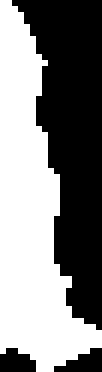
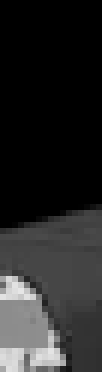

IndexError: boolean index did not match indexed array along dimension 0; dimension is 240 but corresponding boolean dimension is 120

In [40]:
tracked_objects = []
next_label = 1
res_tracking = []

for frame, mask in fm3[1:]:
    n, cc, stats, _ = cv.connectedComponentsWithStats(mask)
    cc_used, next_tracked_objects = set(), []
    if n > 1:
        #Non ho solo il background
        for wnd, hist, label in tracked_objects:
            x, y, w, h = get_new_window(frame, mask, hist, wnd)
            cc_hist, _ = np.histogram(cc[y:y+h, x:x+w], n, (0, n))
            index = np.argmax(cc_hist[1:])+1
            if index not in cc_used and cc_hist[index] >= MIN_ARE_IN_WND:
                wnd, hist = get_window_hist(index, frame, stats, mask) # Un nuovo oggetto viene trovato nell'immagine che non era gia stato etichettato
                next_tracked_objects.append((wnd, hist, label))
                cc_used.add(index)
                
        for i in range(1, n):
            if (stats[i, cv.CC_STAT_AREA] >= MIN_AREA) and (i not in cc_used):
                wnd, hist = get_window_hist(i, frame, stats, mask)
                next_tracked_objects.append((wnd, hist, next_label))
                next_label += 1
        tracked_objects = next_tracked_objects
        
        res = frame.copy()
        
        for (x,y,w,h), hist, label in tracked_objects:
            cv.rectangle(res, (x,y), (x+w, y+h), 255, 2)
            cv.rectangle(res, (x, y-22), (x+w, y), 255, -1)
            cv.putText(res, f"{label}", (x+5, y-5), cv.FONT_HERSHEY_PLAIN, 1, 0, 1)
        
        res_tracking.append(res)